In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import random

%matplotlib inline

In [2]:
calendar = pd.read_csv('./seattle/calendar.csv')
listings = pd.read_csv('./seattle/listings.csv')
reviews = pd.read_csv('./seattle/reviews.csv')

In [3]:
map = gpd.read_file('./seattle/Seattle_Neighborhoods/Seattle_Neighborhoods.shp')
map

,OBJECTID_1,OBJECTID,AREA,PERIMETER,HOODS_,HOODS_ID,S_HOOD,L_HOOD,L_HOODID,SYMBOL,SYMBOL2,geometry
0,1,1,3.588443e+03,617.843,2,0,OOO,None,0,0,0,"POLYGON ((-122.273978953066 47.6952264724238, ..."
1,2,2,2.229478e+04,733.568,3,0,OOO,None,0,0,0,"POLYGON ((-122.287559786155 47.6452274051207, ..."
2,3,3,5.669537e+04,4088.442,5,0,OOO,None,0,0,0,"POLYGON ((-122.395290858286 47.6651350443469, ..."
3,4,4,6.415681e+04,1809.446,6,0,OOO,None,0,0,0,"POLYGON ((-122.398320785776 47.6660877069821, ..."
4,5,5,2.993164e+03,250.330,7,0,OOO,None,0,0,0,"POLYGON ((-122.288512766251 47.6563002277733, ..."
5,6,6,1.137106e+04,408.586,8,0,OOO,None,0,0,0,"POLYGON ((-122.287254209114 47.6553766177367, ..."
6,7,7,1.315780e+04,474.931,9,0,OOO,None,0,0,0,"POLYGON ((-122.286758460534 47.6550635061759, ..."
7,8,8,2.664951e+03,197.126,10,0,OOO,None,0,0,0,"POLYGON ((-122.283116010196 47.654220976317, -..."
8,9,9,1.773268e+03,184.870,11,0,OOO,None,0,0,0,"POLYGON ((-122.294180037479 47.6535476467066, ..."
9,10,10,1.190226e+05,1688.760,12,0,OOO,None,0,0,0,"POLYGON ((-122.294460654735 47.6534247705368, ..."


In [4]:
area_map = map[['geometry','AREA','OBJECTID_1']]


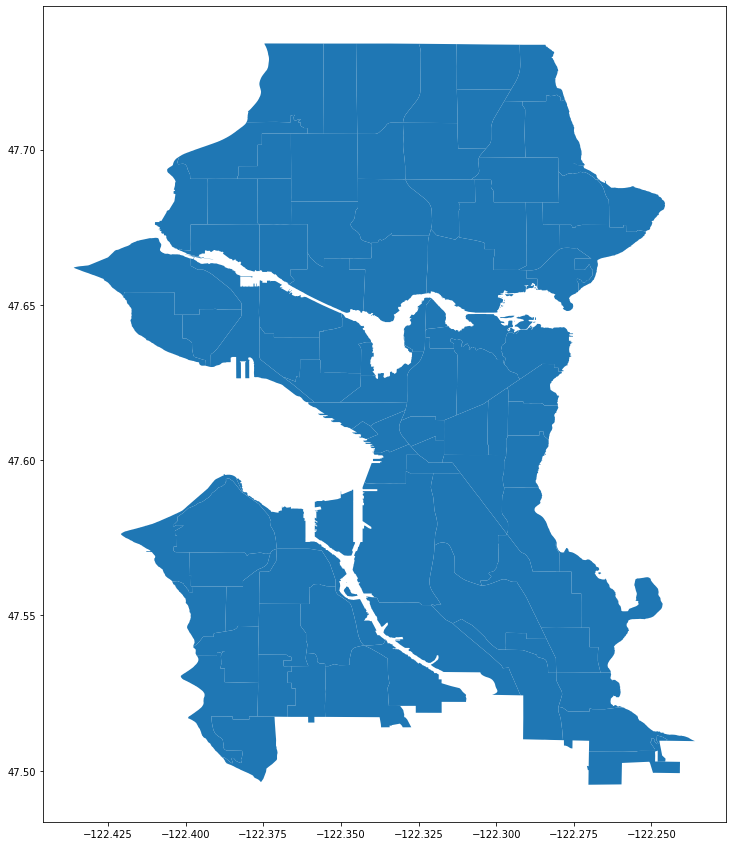

In [5]:
fig,ax = plt.subplots(figsize = (15,15))
map.plot(ax=ax);

In [6]:
geometry = [Point(xy) for xy in zip(listings['longitude'],listings['latitude'])]
crs = {'init':'epsg:4326'}

In [7]:
geo_listings = gpd.GeoDataFrame(listings, crs = crs, geometry = geometry )
geo_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,geometry
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,POINT (-122.3710251999777 47.63628903835718)
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,POINT (-122.3656664643958 47.63912312136253)
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,POINT (-122.3694831756176 47.62972413157735)
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,POINT (-122.3692791226302 47.63847320176642)
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,POINT (-122.3724706340222 47.63291840276724)


In [8]:
airbnb_within_area = gpd.sjoin(geo_listings, area_map, how="inner", op='intersects')
airbnb_within_area['price'] = airbnb_within_area['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float64)


In [9]:
area_by_name = airbnb_within_area[['neighbourhood','OBJECTID_1']].groupby('neighbourhood')['OBJECTID_1'].apply(list).reset_index(name='neighbourhood_id')

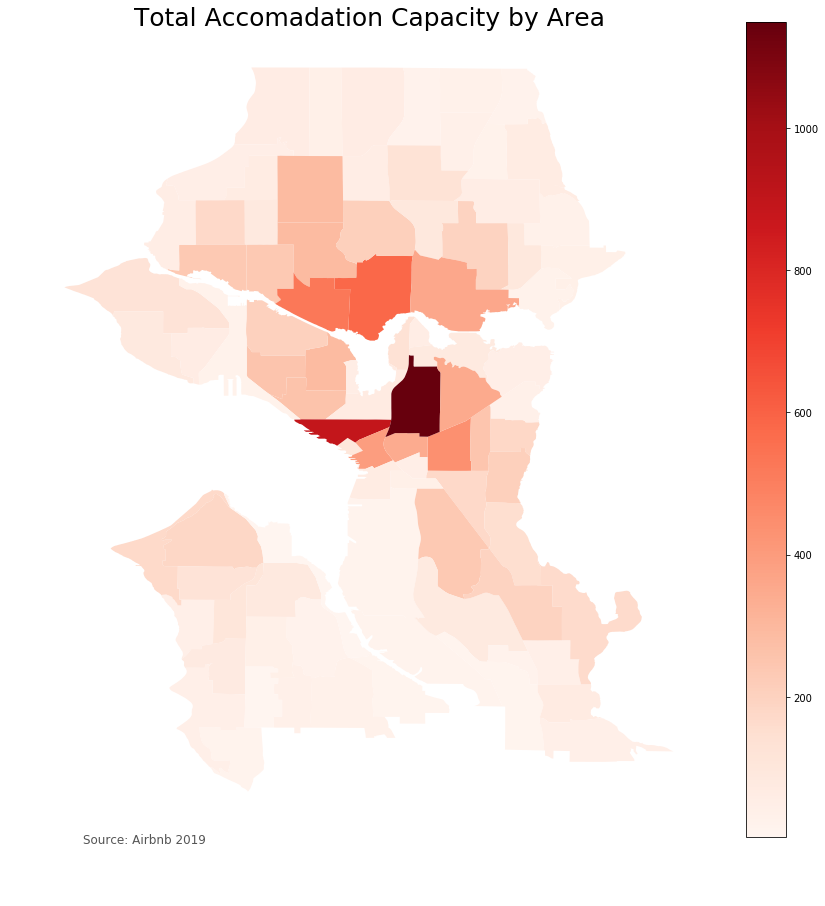

In [10]:
def agg_feat_by_area(df_map, df_feat, feat, colormap, title, agg_type = 'sum'):
    
    if agg_type == 'sum':
        feat_within_area = df_feat[['OBJECTID_1',feat]].groupby('OBJECTID_1', as_index = False).sum()
    if agg_type == 'mean':
        feat_within_area = df_feat[['OBJECTID_1',feat]].groupby('OBJECTID_1', as_index = False).mean()
        
    feat_map = pd.merge(df_map, feat_within_area, on = 'OBJECTID_1', how = 'inner')
    
    fig,ax = plt.subplots(figsize = (15,15))
    
    feat_map.plot(ax = ax, column = feat, cmap = colormap);
    
    ax.axis('off')
    
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    
    ax.annotate('Source: Airbnb 2019',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
    
    vmin, vmax = feat_map[feat].min(), feat_map[feat].max()
    
    sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(vmin=vmin, vmax=vmax))
    
    cbar = fig.colorbar(sm)
    
    return feat_map
    
accommodates_map = agg_feat_by_area(area_map,airbnb_within_area,'accommodates','Reds', 'Total Accomadation Capacity by Area', 'sum')

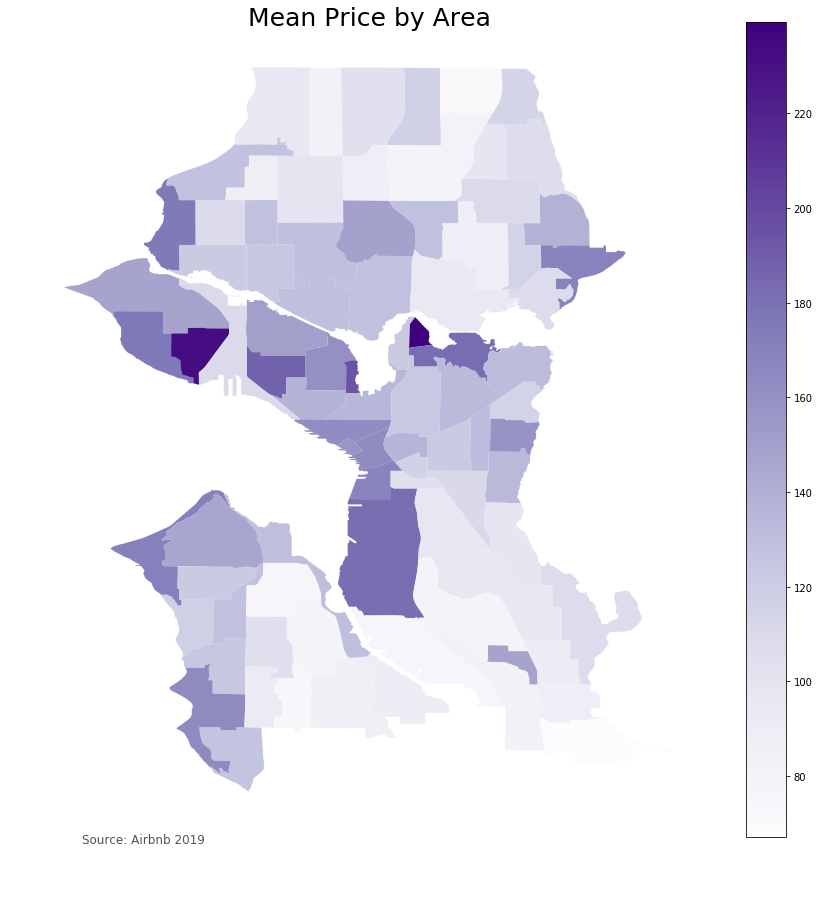

In [11]:
prices_map = agg_feat_by_area(area_map,airbnb_within_area,'price','Purples', 'Mean Price by Area', 'mean')

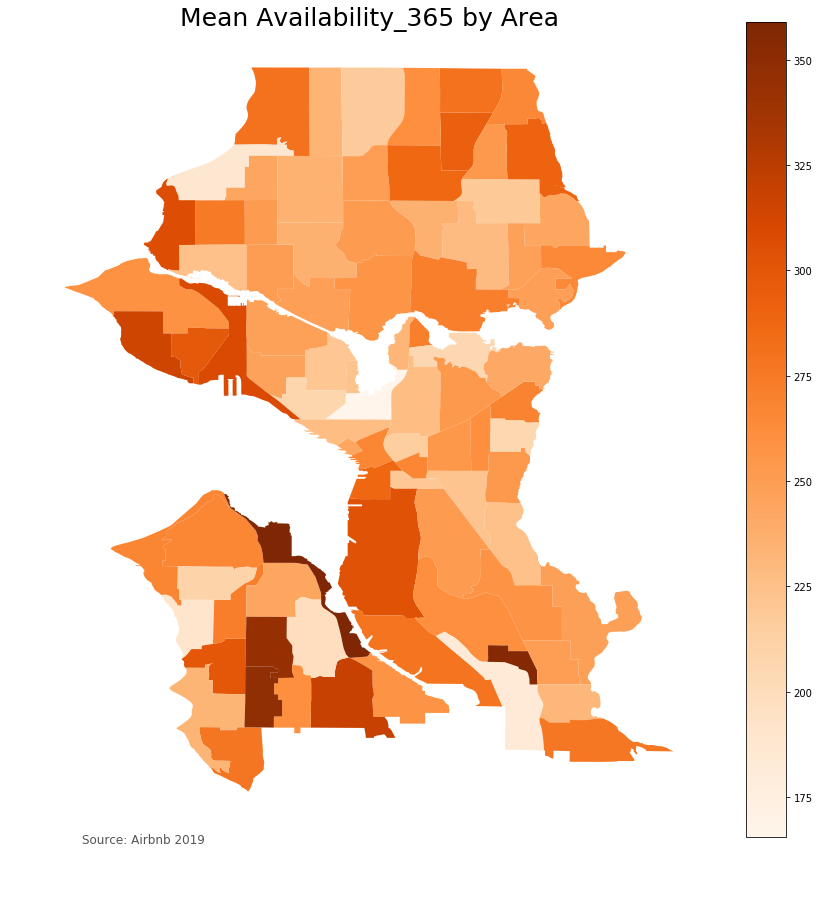

In [12]:
Availability_map = agg_feat_by_area(area_map,airbnb_within_area,'availability_365','Oranges', 'Mean Availability_365 by Area', 'mean')

In [13]:
listings.keys()

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [17]:
listings.instant_bookable

0       f
1       f
2       f
3       f
4       f
5       f
6       f
7       f
8       f
9       f
10      f
11      f
12      f
13      f
14      t
15      f
16      f
17      t
18      f
19      f
20      f
21      f
22      f
23      f
24      f
25      f
26      f
27      f
28      t
29      f
       ..
3788    f
3789    f
3790    t
3791    f
3792    f
3793    t
3794    f
3795    f
3796    t
3797    f
3798    f
3799    f
3800    f
3801    f
3802    f
3803    f
3804    f
3805    f
3806    f
3807    f
3808    f
3809    f
3810    f
3811    f
3812    t
3813    f
3814    f
3815    f
3816    f
3817    f
Name: instant_bookable, Length: 3818, dtype: object

In [15]:
listings_copy = listings.copy()

listings_copy['price'] = listings_copy['price'].apply(lambda x: x.replace('$','')).apply(lambda x: x.replace(',','')).astype(np.float64)


mean_price_by_neighbourhood = listings_copy[['neighbourhood','price']].groupby('neighbourhood').mean()
mean_price_by_neighbourhood

,price
neighbourhood,
Alki,196.652174
Arbor Heights,118.000000
Atlantic,116.280000
Ballard,123.615023
Belltown,166.627451
Bitter Lake,78.846154
Brighton,78.000000
Broadview,102.875000
Broadway,128.400000
